# 물류 유통량 예측 경진대회

제주시 내 택배 운송 데이터를 이용하여 운송량 예측 AI 개발

https://dacon.io/en/competitions/official/235867/overview/description

##  0. 한글 폰트

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,645 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126209 files and dire

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
!pip install catboost
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 16.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error

import random
import optuna
from optuna.samplers import TPESampler

In [ ]:
!pip uninstall numpy catboost
!pip install numpy catboost


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.11/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
                        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/req/req_install.py", line 722, in uni

In [ ]:
import pandas as pd
import optuna
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 로드

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/2025-1/DATA/train.csv', encoding='utf-8')
test_df = pd.read_csv('/content/drive/MyDrive/2025-1/DATA/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/2025-1/DATA/sample_submission.csv')

In [ ]:
train = train_df.copy()
test = test_df.copy()

# EDA

## 1) 타겟 변수 살펴보기

### 운송장 건수 분포

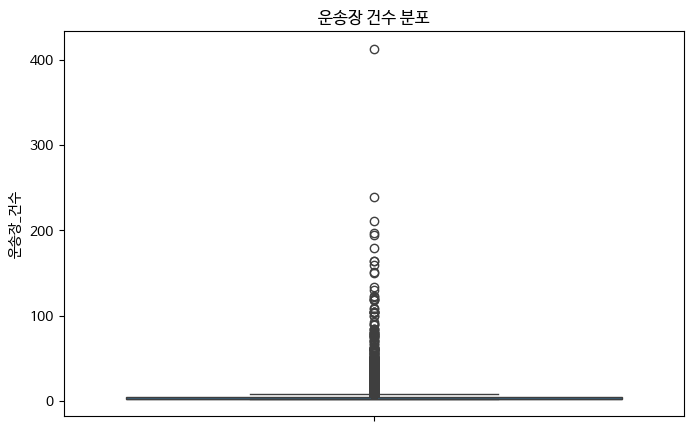

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(train["운송장_건수"])
plt.title("운송장 건수 분포")
plt.show()

- 왜도가 매우 심함 -> 로그 취해 정규화 시도
- 뚜렷한 이상치 존재

이상치 확인하기

In [ ]:
# 이상치 확인해보기
outliers = train[(train['운송장_건수']>300)]
outliers

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
25394,25394,4117300018005400,5011000168096300,기타패션의류,413


In [ ]:
# # test에 비슷한 값이 있는지 확인
# test_outliers = test[
#     (test['수하인_격자공간고유번호'] == 5011000168096300) |
#     (test['송하인_격자공간고유번호'] == 4117300018005400)
# ]
# test_outliers

=> train의 이상치 값과 유사한 test의 데이터가 존재함 -> 이상치 제거는 고민해봐야 함

### '운송장_건수' 정규화

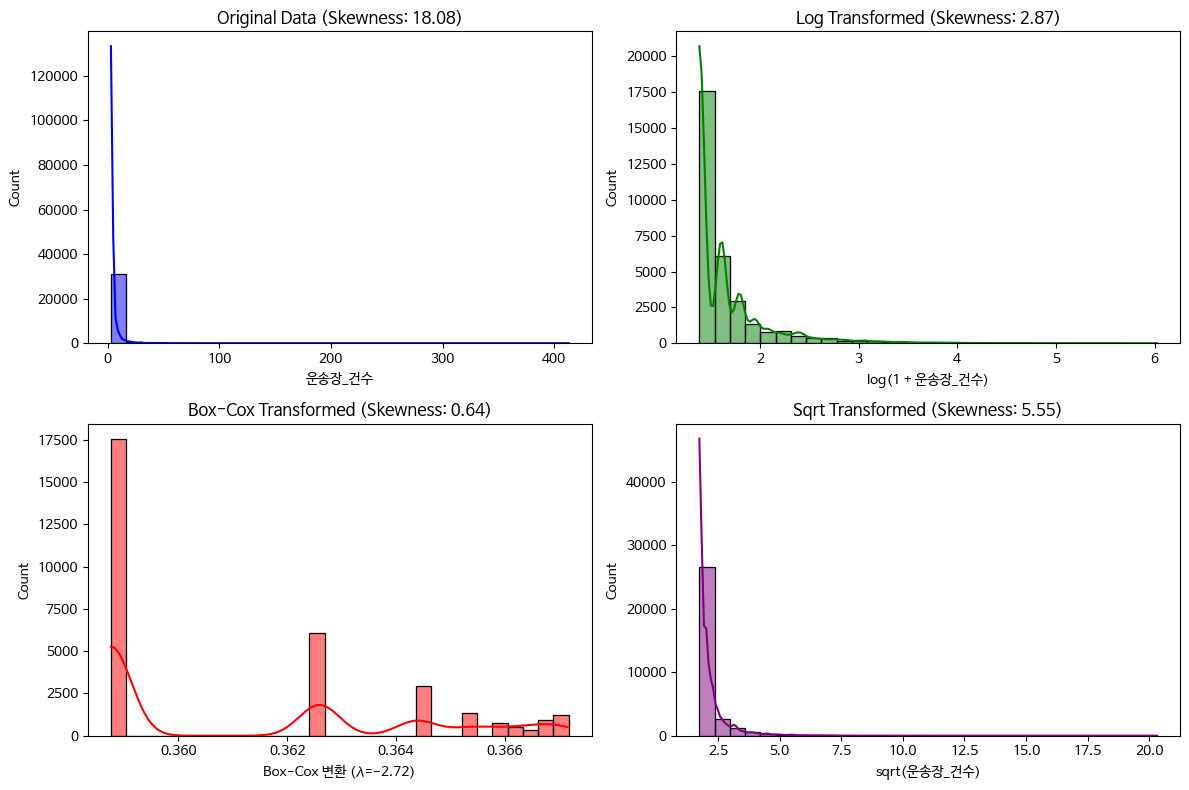

원본 데이터 왜도: 18.08
로그 변환 후 왜도: 2.87
Box-Cox 변환 후 왜도: 0.64 (λ=-2.72)
제곱근 변환 후 왜도: 5.55


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, boxcox

# 데이터 복사 (결측값 제거)
data = train['운송장_건수'].dropna()

# 1. 원본 데이터 왜도 계산
original_skew = skew(data)

# 2. 로그 변환 (0 이상인 값만 사용)
log_data = np.log1p(data)  # log(1 + x) 변환
log_skew = skew(log_data)

# 3. Box-Cox 변환 (양수 데이터만 가능, 0 이상 필터링)
boxcox_data, lambda_val = boxcox(data + 1)  # 0을 방지하기 위해 +1
boxcox_skew = skew(boxcox_data)

# 4. 제곱근 변환 (sqrt)
sqrt_data = np.sqrt(data)
sqrt_skew = skew(sqrt_data)

# 5. 히스토그램 & 왜도 비교 (2×2 서브플롯)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 원본 데이터
sns.histplot(data, kde=True, bins=30, color='blue', ax=axes[0, 0])
axes[0, 0].set_title(f"Original Data (Skewness: {original_skew:.2f})")
axes[0, 0].set_xlabel("운송장_건수")

# 로그 변환 데이터
sns.histplot(log_data, kde=True, bins=30, color='green', ax=axes[0, 1])
axes[0, 1].set_title(f"Log Transformed (Skewness: {log_skew:.2f})")
axes[0, 1].set_xlabel("log(1 + 운송장_건수)")

# Box-Cox 변환 데이터
sns.histplot(boxcox_data, kde=True, bins=30, color='red', ax=axes[1, 0])
axes[1, 0].set_title(f"Box-Cox Transformed (Skewness: {boxcox_skew:.2f})")
axes[1, 0].set_xlabel(f"Box-Cox 변환 (λ={lambda_val:.2f})")

# 제곱근 변환 데이터
sns.histplot(sqrt_data, kde=True, bins=30, color='purple', ax=axes[1, 1])
axes[1, 1].set_title(f"Sqrt Transformed (Skewness: {sqrt_skew:.2f})")
axes[1, 1].set_xlabel("sqrt(운송장_건수)")

plt.tight_layout()
plt.show()

# 왜도 출력
print(f"원본 데이터 왜도: {original_skew:.2f}")
print(f"로그 변환 후 왜도: {log_skew:.2f}")
print(f"Box-Cox 변환 후 왜도: {boxcox_skew:.2f} (λ={lambda_val:.2f})")
print(f"제곱근 변환 후 왜도: {sqrt_skew:.2f}")


=> 다양한 방법을 사용했으나 정규화 진행이 되지 않음 : Box-cox 변환 방법이 가장 효과가 좋음


## 2) 송하인_격자공간고유번호, 수하인_격자공간고유번호 칼럼 분석

**송하인_격자공간고유번호**

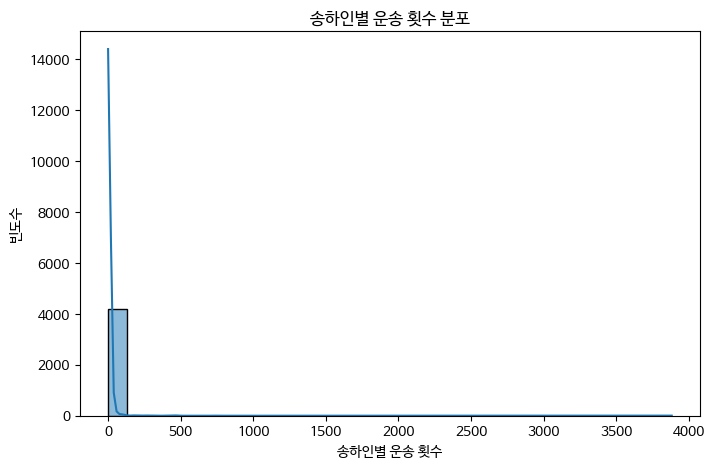

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(train["송하인_격자공간고유번호"].astype(str).value_counts(), bins=30, kde=True)
plt.title("송하인별 운송 횟수 분포")
plt.xlabel("송하인별 운송 횟수")
plt.ylabel("빈도수")
plt.show()

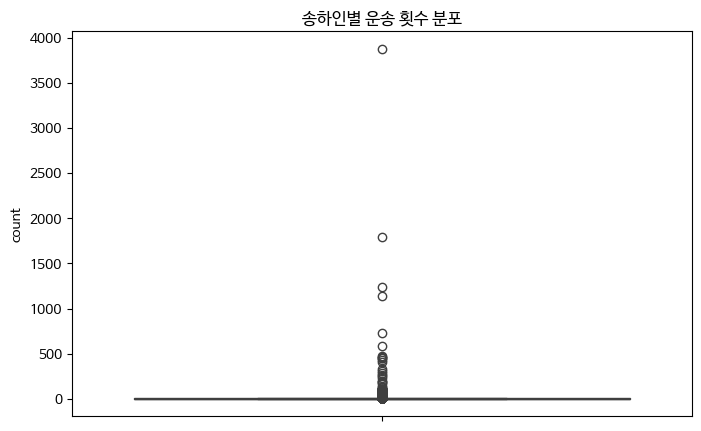

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(train["송하인_격자공간고유번호"].astype(str).value_counts())
plt.title("송하인별 운송 횟수 분포")
plt.show()

**수하인_격자공간고유번호**

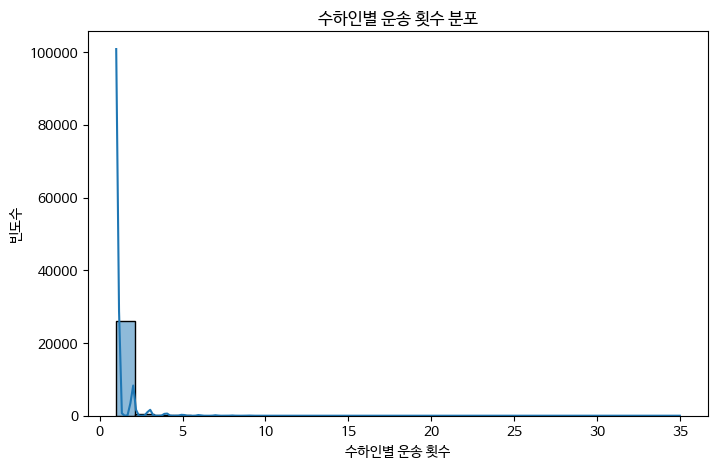

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(train["수하인_격자공간고유번호"].astype(str).value_counts(), bins=30, kde=True)
plt.title("수하인별 운송 횟수 분포")
plt.xlabel("수하인별 운송 횟수")
plt.ylabel("빈도수")
plt.show()

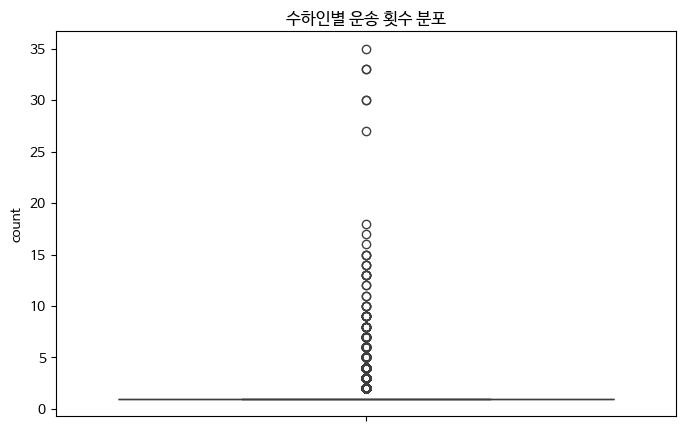

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(train["수하인_격자공간고유번호"].astype(str).value_counts())
plt.title("수하인별 운송 횟수 분포")
plt.show()

- "송하인_격자공간고유번호", "수하인_격자공간고유번호"의 칼럼들을 살펴보았을 때, "수하인_격자공간고유번호"의 고유값이 상당히 많다.
- 아마도 물품을 제작, 생산하여 보내는 곳들의 수는 적지만, 이후 소비자나 소매상 등에서 물품을 구매하여 배송을 받기 때문에, 물품들은 송하인에서 수하인에게 넓게 퍼져나가는 형태이기 때문이다.



**'송하인_격자공간고유번호' 와 '물품_카테고리' 간 관계**

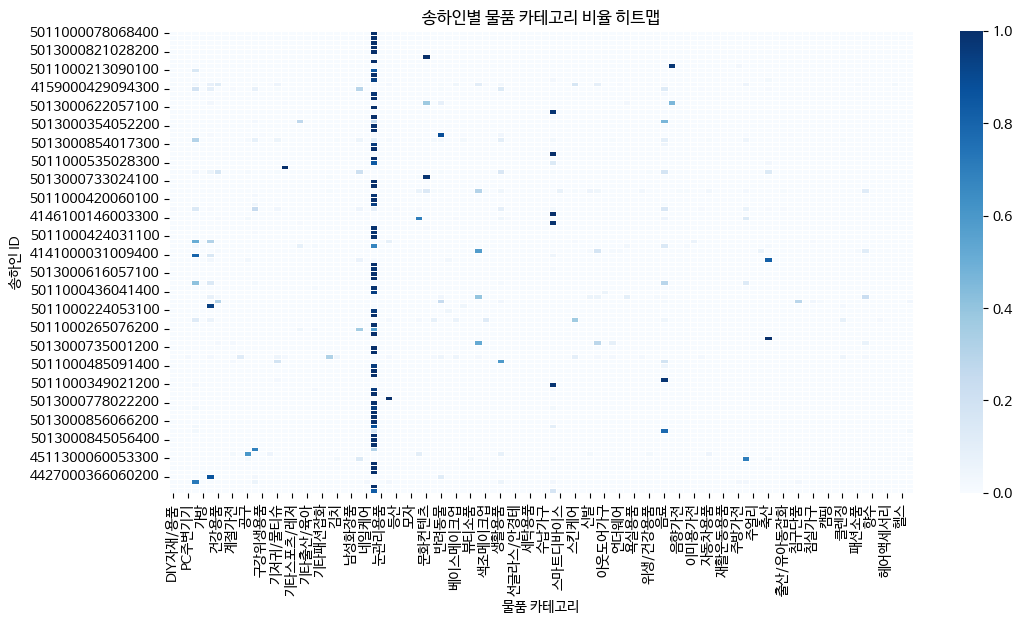

In [ ]:
import seaborn as sns

# 송하인별로 가장 많이 보내는 물품 카테고리 찾기
top_senders = train["송하인_격자공간고유번호"].value_counts().index[:100]
category_counts = train.groupby(["송하인_격자공간고유번호", "물품_카테고리"]).size().unstack(fill_value=0)

# 송하인별 물품 카테고리 비율
category_ratio = category_counts.div(category_counts.sum(axis=1), axis=0).loc[top_senders]

plt.figure(figsize=(12, 6))
sns.heatmap(category_ratio, cmap="Blues", linewidths=0.5)
plt.xlabel("물품 카테고리")
plt.ylabel("송하인 ID")
plt.title("송하인별 물품 카테고리 비율 히트맵")
plt.show()

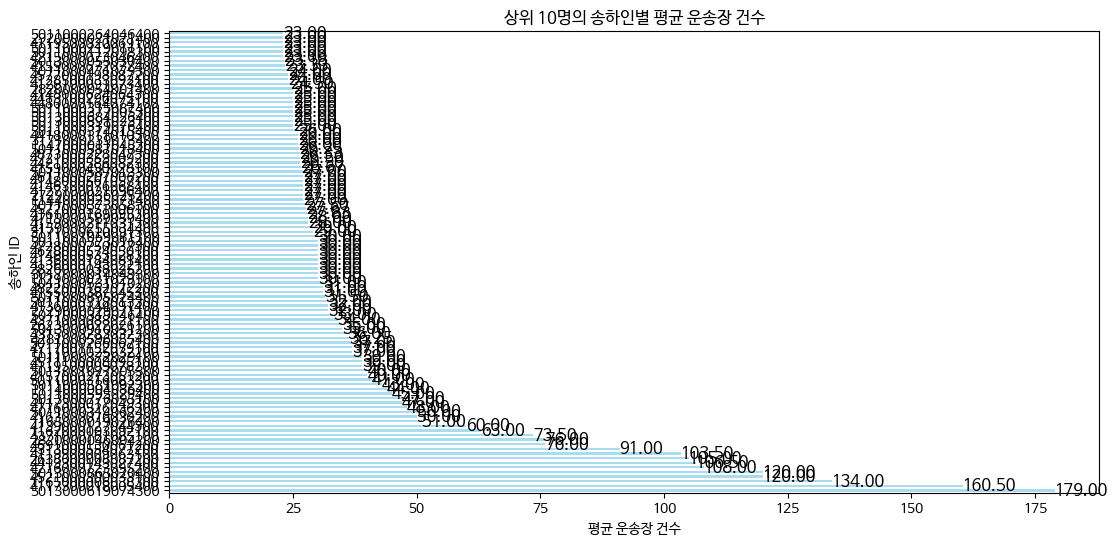

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 송하인별 평균 운송장 건수 계산
sender_mean_parcels = train.groupby("송하인_격자공간고유번호")["운송장_건수"].mean()

# 평균 운송장 건수가 높은 상위 10명의 송하인 선택
top_senders = sender_mean_parcels.nlargest(100)

# 막대 그래프 그리기
plt.figure(figsize=(12, 6))
top_senders.sort_values().plot(kind="barh", color="skyblue", alpha=0.7)

# 그래프 제목 및 축 라벨 설정
plt.xlabel("평균 운송장 건수")
plt.ylabel("송하인 ID")
plt.title("상위 10명의 송하인별 평균 운송장 건수")
plt.gca().invert_yaxis()  # y축 뒤집기 (송하인 순서 정렬)

# 값 표시
for index, value in enumerate(top_senders.sort_values()):
    plt.text(value, index, f"{value:.2f}", ha='left', va='center', fontsize=12)

plt.show()

=> 물품을 제작, 생산하는 곳들에 따라 물품의 카테고리나 운송 건수가 달라진다.

더 나아가, 자료조사 결과, 이러한 배송에 사용되는 고유번호의 경우 각 자릿수마다 뜻하는 바가 있을 수도 있다. (연속형으로 취급하면 안됨.) 따라서 각 자릿수 별로 새로운 변수를 생성하는 것을 고려해봐야한다.

# 전처리

## 1) '수하인_격자공간고유번호' 변수 삭제

'수하인_격자공간고유번호' 와 다른 변수 간 관계성이 크지 않음

In [ ]:
train = train.drop(['수하인_격자공간고유번호'], axis=1)
test = test.drop(['수하인_격자공간고유번호'], axis=1)

## 2) 고유번호 나누기

https://www.allproductkorea.or.kr/products/database/category

위의 사이트를 참고하여 고유번호의 자리 수를 나누기


고유번호를 아래와 같이 나누기

---

**시도 / 시구군 / 읍면동 / 리 / 상품번호**

**1-2 / 3-5 / 6-8 / 9-10 / 11-16**

---

In [ ]:
# '시군' : 1-2자리
train['송하인_시도'] = train['송하인_격자공간고유번호'].astype(str).str[:2]

# '시구군' : 3-5자리
train['송하인_시구군'] = train['송하인_격자공간고유번호'].astype(str).str[2:5]

# '읍면동' : 6-8자리
train['송하인_읍면동'] = train['송하인_격자공간고유번호'].astype(str).str[5:8]

# '리' : 9-10자리
train['송하인_리'] = train['송하인_격자공간고유번호'].astype(str).str[8:10]

# '상품번호' : 11-16자리
train['송하인_상품번호'] = train['송하인_격자공간고유번호'].astype(str).str[10:16]

# 고유값 확인
train.nunique()

,0
index,31684
송하인_격자공간고유번호,4229
물품_카테고리,100
운송장_건수,100
송하인_시도,17
송하인_시구군,99
송하인_읍면동,14
송하인_리,100
송하인_상품번호,400


In [ ]:
# '시도' : 1-2자리
test['송하인_시도'] = test['송하인_격자공간고유번호'].astype(str).str[:2]

# '시구군' : 3-5자리
test['송하인_시구군'] = test['송하인_격자공간고유번호'].astype(str).str[2:5]

# '읍면동' : 6-8자리
test['송하인_읍면동'] = test['송하인_격자공간고유번호'].astype(str).str[5:8]

# '리' : 9-10자리
test['송하인_리'] = test['송하인_격자공간고유번호'].astype(str).str[8:10]

# '상품번호' : 11-16자리
test['송하인_상품번호'] = test['송하인_격자공간고유번호'].astype(str).str[10:16]
test.nunique()

,0
index,7920
송하인_격자공간고유번호,1812
물품_카테고리,100
송하인_시도,17
송하인_시구군,95
송하인_읍면동,13
송하인_리,100
송하인_상품번호,396


In [ ]:
# train 데이터 확인
train.head()

,index,송하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_시도,송하인_시구군,송하인_읍면동,송하인_리,송하인_상품번호
0,0,5011000595017300,음반,3,50,110,005,95,017300
1,1,4148000690043300,문화컨텐츠,3,41,480,006,90,043300
2,2,5011000078068400,농산물,3,50,110,000,78,068400
3,3,4127100048006400,기타식품,7,41,271,000,48,006400
4,4,5011000078068400,농산물,3,50,110,000,78,068400


In [ ]:
test.head()

,index,송하인_격자공간고유번호,물품_카테고리,송하인_시도,송하인_시구군,송하인_읍면동,송하인_리,송하인_상품번호
0,0,4167000577042200,선케어,41,670,005,77,042200
1,1,1156000009012200,구강위생용품,11,560,000,09,012200
2,2,4122000363057300,캠핑,41,220,003,63,057300
3,3,5011000436041400,아웃도어가구,50,110,004,36,041400
4,4,4150000241065200,분유/이유식/아기간식,41,500,002,41,065200


## 3) 물품 카테고리 대분류

https://www.allproductkorea.or.kr/products/database/category


**대분류코드 별 물품_카테고리**

- 01 (가공식품) :'기타식품' '건강식품' '음료' '가공식품' '과자' '다이어트식품' '냉동간편조리식품' '김치' '분유/이유식/아기간식' '반찬'

- 02 (신선식품) :'농산물' '수산' '축산'

- 03 (일상용품) :'헤어케어' '기저귀/물티슈' '건강용품' '바디케어' '반려동물' '생활용품' '선케어' '네일케어' '기타화장품/미용' '주방용품' '클렌징' '공구' '헤어스타일링' '위생/건강용품' '자동차용품' '수납/정리용품' '남성화장품' '향수' '구강위생용품' '눈관리용품' '기타출산/육아' '욕실용품' '세탁용품'

- 05 (의약품/의료기기) :'문화컨텐츠' '의료용품'

- 06 (교육/문화용품) :'음반' '완구/매트' '문구/사무용품' '취미용품' '출산/유아동잡화'

- 07 (디지털/가전) :'기타디지털/가전' '모니터' '이미용가전' 'PC' '주방가전' 'PC주변기기' '음향가전' '계절가전' '스마트디바이스액세서리' '게임기/타이틀' '생활가전' '태블릿PC/노트북액세서리' '스마트디바이스'

- 08 (가구/인테리어) :'서재/사무용가구' '침구세트' '침구단품' '인테리어소품' '커튼/블라인드' '주방가구' 'DIY자재/용품' '침실가구' '수납가구' '홈데코' '카페트/러그' '유아가구'

- 09 (의류) :'아우터' '상의' '출산/유아동의류' '하의' '기타패션의류' '잠옷' '언더웨어' '원피스/점프슈트' '기능성'

- 10 (전문스포츠/레저) :'기타스포츠/레저' '등산' '낚시' '재활운동용품' '골프' '스포츠잡화' '아웃도어가구' '캠핑' '헬스'

- 11 (패션잡화) :'신발' '선글라스/안경테' '양말/스타킹' '헤어액세서리' '가방' '패션소품' '모자' '기타패션잡화' '지갑'

- 20 (화장품) :'스킨케어' '색조메이크업' '뷰티소품' '주얼리' '베이스메이크업'

In [ ]:
import pandas as pd

# 카테고리 매핑 딕셔너리 생성
category_mapping = {
    "DIY자재/용품": "08", "PC주변기기": "07", "가방": "11", "건강용품": "03", "계절가전": "07",
    "공구": "03", "구강위생용품": "03", "기저귀/물티슈": "03", "기타스포츠/레저": "10", "기타출산/육아": "03",
    "기타패션잡화": "11", "김치": "01", "남성화장품": "03", "네일케어": "03", "눈관리용품": "03",
    "등산": "10", "모자": "11", "문화컨텐츠": "05", "반려동물": "03", "베이스메이크업": "20",
    "뷰티소품": "20", "색조메이크업": "20", "생활용품": "03", "선글라스/안경테": "11", "세탁용품": "03",
    "수납가구": "08", "스마트디바이스": "07", "스킨케어": "20", "신발": "11", "아웃도어가구": "10",
    "언더웨어": "09", "욕실용품": "03", "위생/건강용품": "03", "음료": "01", "음향가전": "07",
    "이미용가전": "07", "자동차용품": "03", "주방가전": "07", "주얼리": "20", "축산": "02",
    "침구단품": "08", "침실가구": "08", "캠핑": "10", "클렌징": "03", "패션소품": "11",
    "향수": "03", "헤어악세서리": "20", "헬스": "10", "음반":"06", "농산물":"02", "기타식품":"01",
    "스포츠잡화":"10", "지갑":"11", "가공식품":"01", "수산":"02", "건강식품":"01","스마트디바이스액세서리":"07",
    "아우터":"09","상의":"09","원피스/점프슈트":"09","기타디지털/가전":"07","낚시":"10", "문구사무용품":"06",
    "헤어케어":"03","바디케어":"03","완구/매트":"06","게임기/타이틀":"07","침구세트":"08","하의":"09",
    "과자":"01","의료용품":"05","출산/유아동의류":"09","취미용품":"06","문구/사무용품":"06","선케어":"03",
    "냉동/간편조리식품":"01","다이어트식품":"01","기타패션의류":"09", "기타화장품/미용":"03","서재/사무용가구":"08",
    "양말/스타킹":"11","지갑":"11","세탁용품":"03","주방용품":"03","헤어악세사리":"11","스마트디바이스":"07",
    "인테리어소품":"08","모니터":"07","생활가전":"07","기능성":"09","PC":"07","커튼/블라인드":"08","헤어스타일링":"03",
    "헤어액세서리":"11","홈데코":"08","주방가구":"08","카페트/러그":"08","태블릿PC/노트북액세서리":"07",
    "잠옷":"09","골프":"10","수납/정리용품":"03","출산/유아동잡화":"06","분유/이유식/아기간식":"01","반찬":"01",
    "유아가구":"08","재활운동용품":"10" #헷갈림
}

# '대분류코드' 칼럼 추가
train["대분류코드"] = train["물품_카테고리"].map(category_mapping)

train

,index,송하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_시도,송하인_시구군,송하인_읍면동,송하인_리,송하인_상품번호,대분류코드
0,0,5011000595017300,음반,3,50,110,005,95,017300,06
1,1,4148000690043300,문화컨텐츠,3,41,480,006,90,043300,05
2,2,5011000078068400,농산물,3,50,110,000,78,068400,02
3,3,4127100048006400,기타식품,7,41,271,000,48,006400,01
4,4,5011000078068400,농산물,3,50,110,000,78,068400,02
...,...,...,...,...,...,...,...,...,...,...
31679,31679,4471000290087200,스포츠잡화,3,44,710,002,90,087200,10
31680,31680,1129000014045300,스마트디바이스,4,11,290,000,14,045300,07
31681,31681,1129000014045300,스마트디바이스,6,11,290,000,14,045300,07
31682,31682,4127300065073100,지갑,7,41,273,000,65,073100,11


In [ ]:
train[train['대분류코드'].isna()]

,index,송하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_시도,송하인_시구군,송하인_읍면동,송하인_리,송하인_상품번호,대분류코드


In [ ]:
# '대분류코드' 칼럼 추가 (test 데이터셋)
test["대분류코드"] = test["물품_카테고리"].map(category_mapping)

# 결과 확인
print(test[['물품_카테고리', '대분류코드']].head())

       물품_카테고리 대분류코드
0          선케어    03
1       구강위생용품    03
2           캠핑    10
3       아웃도어가구    10
4  분유/이유식/아기간식    01


## 4) 라벨 인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코더 생성
label_encoder_1 = LabelEncoder()
label_encoder_2 = LabelEncoder()

# '물품_카테고리'와 '대분류코드'에 라벨 인코딩 적용
train["물품_카테고리_인코딩"] = label_encoder_1.fit_transform(train["물품_카테고리"])
train["대분류코드_인코딩"] = label_encoder_2.fit_transform(train["대분류코드"])

# 변환된 값 확인
print(train[["물품_카테고리", "물품_카테고리_인코딩", "대분류코드", "대분류코드_인코딩"]].head())

  물품_카테고리  물품_카테고리_인코딩 대분류코드  대분류코드_인코딩
0      음반           67    06          4
1   문화컨텐츠           34    05          3
2     농산물           27    02          1
3    기타식품           17    01          0
4     농산물           27    02          1


In [ ]:
# 물품_카테고리 라벨 인코딩
test["물품_카테고리_인코딩"] = label_encoder_1.transform(test["물품_카테고리"])

# 대분류코드 라벨 인코딩
test["대분류코드_인코딩"] = label_encoder_2.transform(test["대분류코드"])

In [ ]:
# 송하인 시도/ 시군구/ 읍면동/리/상품번호 라벨인코딩
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩을 위한 LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# '송하인_시도', '송하인_시구군', '송하인_읍면동', '송하인_리'에 대해 라벨 인코딩
train['송하인_시도_인코딩'] = label_encoder.fit_transform(train['송하인_시도'])
train['송하인_시구군_인코딩'] = label_encoder.fit_transform(train['송하인_시구군'])
train['송하인_읍면동_인코딩'] = label_encoder.fit_transform(train['송하인_읍면동'])
train['송하인_리_인코딩'] = label_encoder.fit_transform(train['송하인_리'])
train['송하인_상품번호'] = label_encoder.fit_transform(train['송하인_상품번호'])

# test 데이터셋에도 동일한 라벨 인코딩을 적용
test['송하인_시도_인코딩'] = label_encoder.fit_transform(test['송하인_시도'])
test['송하인_시구군_인코딩'] = label_encoder.fit_transform(test['송하인_시구군'])
test['송하인_읍면동_인코딩'] = label_encoder.fit_transform(test['송하인_읍면동'])
test['송하인_리_인코딩'] = label_encoder.fit_transform(test['송하인_리'])
test['송하인_상품번호'] = label_encoder.fit_transform(test['송하인_상품번호'])

In [ ]:
train.columns
test.columns

Index(['index', '송하인_격자공간고유번호', '물품_카테고리', '송하인_시도', '송하인_시구군', '송하인_읍면동',
       '송하인_리', '송하인_상품번호', '대분류코드', '물품_카테고리_인코딩', '대분류코드_인코딩', '송하인_시도_인코딩',
       '송하인_시구군_인코딩', '송하인_읍면동_인코딩', '송하인_리_인코딩'],
      dtype='object')

In [ ]:
train.head()

,index,송하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_시도,송하인_시구군,송하인_읍면동,송하인_리,송하인_상품번호,대분류코드,물품_카테고리_인코딩,대분류코드_인코딩,송하인_시도_인코딩,송하인_시구군_인코딩,송하인_읍면동_인코딩,송하인_리_인코딩
0,0,5011000595017300,음반,3,50,110,005,95,66,06,67,4,16,0,5,95
1,1,4148000690043300,문화컨텐츠,3,41,480,006,90,170,05,34,3,8,61,6,90
2,2,5011000078068400,농산물,3,50,110,000,78,271,02,27,1,16,0,0,78
3,3,4127100048006400,기타식품,7,41,271,000,48,23,01,17,0,8,37,0,48
4,4,5011000078068400,농산물,3,50,110,000,78,271,02,27,1,16,0,0,78


____
# **[경우의 수 별 데이터 생성]**


## 모델 비교

- 원본 데이터(정규화X)로 확인 ver.

In [ ]:
# # all_estimators 적용
# import gc
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.utils import all_estimators
# from sklearn.cross_decomposition import CCA

# # 예제 데이터셋 (train 데이터 준비된 상태)
# X = train.drop(['운송장_건수','운송장_건수_scaled'], axis=1)
# y = train['운송장_건수']

# # train-test split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # 훈련 데이터 50% 샘플링 (동일 인덱스로 X와 y 모두 샘플링)
# X_train_sampled = X_train.sample(frac=0.5, random_state=42)
# y_train_sampled = y_train.loc[X_train_sampled.index]

# # 모든 회귀 모델 가져오기
# estimators = all_estimators(type_filter='regressor')

# results = []
# for name, model_class in estimators:
#     try:
#         # CCA인 경우는 n_components=1로 설정
#         if name == "CCA":
#             model = CCA(n_components=1)
#         else:
#             model = model_class()
#             if hasattr(model, 'n_jobs'):
#                 model.set_params(n_jobs=-1)
#         model.fit(X_train_sampled, y_train_sampled)
#         y_pred = model.predict(X_val)
#         mse = mean_squared_error(y_val, y_pred)
#         results.append((name, mse))
#         del model
#         gc.collect()
#     except Exception as e:
#         print(f"⚠ 모델 {name} 실행 오류: {e}")

# results_df = pd.DataFrame(results, columns=['Model', 'MSE']).sort_values(by='MSE', ascending=True)
# print(results_df.head(4))

- 정규화 데이터로 확인 ver.

In [ ]:
'''
# all_estimators 적용
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import all_estimators
from sklearn.cross_decomposition import CCA

# 예제 데이터셋 (train 데이터 준비된 상태)
X = train.drop(['운송장_건수','운송장_건수_scaled'], axis=1)
y = train['운송장_건수_scaled']

# train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 훈련 데이터 50% 샘플링 (동일 인덱스로 X와 y 모두 샘플링)
X_train_sampled = X_train.sample(frac=0.5, random_state=42)
y_train_sampled = y_train.loc[X_train_sampled.index]

# 모든 회귀 모델 가져오기
estimators = all_estimators(type_filter='regressor')

results = []
for name, model_class in estimators:
    try:
        # CCA인 경우는 n_components=1로 설정
        if name == "CCA":
            model = CCA(n_components=1)
        else:
            model = model_class()
            if hasattr(model, 'n_jobs'):
                model.set_params(n_jobs=-1)
        model.fit(X_train_sampled, y_train_sampled)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        results.append((name, mse))
        del model
        gc.collect()
    except Exception as e:
        print(f"⚠ 모델 {name} 실행 오류: {e}")

results_df = pd.DataFrame(results, columns=['Model', 'MSE']).sort_values(by='MSE', ascending=True)
print(results_df.head(4))
'''

'\n# all_estimators 적용\nimport gc\nimport pandas as pd\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.utils import all_estimators\nfrom sklearn.cross_decomposition import CCA\n\n# 예제 데이터셋 (train 데이터 준비된 상태)\nX = train.drop([\'운송장_건수\',\'운송장_건수_scaled\'], axis=1)\ny = train[\'운송장_건수_scaled\']\n\n# train-test split\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# 훈련 데이터 50% 샘플링 (동일 인덱스로 X와 y 모두 샘플링)\nX_train_sampled = X_train.sample(frac=0.5, random_state=42)\ny_train_sampled = y_train.loc[X_train_sampled.index]\n\n# 모든 회귀 모델 가져오기\nestimators = all_estimators(type_filter=\'regressor\')\n\nresults = []\nfor name, model_class in estimators:\n    try:\n        # CCA인 경우는 n_components=1로 설정\n        if name == "CCA":\n            model = CCA(n_components=1)\n        else:\n            model = model_class()\n            if hasattr(model, \'n_jobs\'):\n                model.set_par

🔽 경우의 수 별 all_estimators 결과 정리

(1) 송하인_운송장_비율 / 원본데이터 / 이상치 삭제
```
                               Model        MSE
14  HistGradientBoostingRegressor  33.279772
2                BaggingRegressor  34.073814
13      GradientBoostingRegressor  34.271504
37          RandomForestRegressor  34.395460
```
(2) 송하인_운송장_비율 / 원본데이터 / 이상치 대체
```
                           Model       MSE
14  HistGradientBoostingRegressor  1.200554
13      GradientBoostingRegressor  1.201645
24                    LassoLarsIC  1.265347
3                   BayesianRidge  1.265376
```

(3) 송하인_운송장_비율 / 정규화데이터 / 이상치 삭제 ✅
```
                            Model       MSE
13  HistGradientBoostingRegressor  0.238637
12      GradientBoostingRegressor  0.241954
1               AdaBoostRegressor  0.249752
35          RandomForestRegressor  0.251882
```
(4) 송하인_운송장_비율 / 정규화데이터 / 이상치 대체 ✅
```
                            Model       MSE
13  HistGradientBoostingRegressor  0.300867
12      GradientBoostingRegressor  0.300921
1               AdaBoostRegressor  0.305489
23                    LassoLarsIC  0.323264
```
(5) 송하인_카테고리별_변수 / 원본데이터 / 이상치 삭제
```
          Model        MSE
21       LassoCV  22.888969
8   ElasticNetCV  23.055820
22     LassoLars  23.139719
20         Lasso  23.139896
```

(6) 송하인_카테고리별_변수 / 원본데이터 / 이상치 대체
```
           Model       MSE
0   ARDRegression  0.957226
24    LassoLarsIC  0.958236
23    LassoLarsCV  0.958252
17    KernelRidge  0.958267
```

(7) 송하인_카테고리별_변수 / 정규화데이터 / 이상치 삭제 ✅
```
                            Model       MSE
12      GradientBoostingRegressor  0.196612
13  HistGradientBoostingRegressor  0.199520
1               AdaBoostRegressor  0.205871
35          RandomForestRegressor  0.221524
```

(8) 송하인_카테고리별_변수 / 정규화데이터 / 이상치 대체 ✅
```
                            Model       MSE
12      GradientBoostingRegressor  0.265534
13  HistGradientBoostingRegressor  0.266808
1               AdaBoostRegressor  0.276631
35          RandomForestRegressor  0.297645
```

____
**[경우의 수 별 데이터 생성]**

- 송하인_운송장_비율 / 정규화데이터 / 이상치 삭제 -> train1 생성
- 송하인_운송장_비율 / 정규화데이터 / 이상치 대체 -> train2 생성
- 송하인_카테고리별_변수 / 정규화데이터 / 이상치 삭제 (성능 가장 좋음) -> train3 생성
- 송하인_카테고리별_변수 / 정규화데이터 / 이상치 대체 -> train4 생성

총 4가지의 경우로 각각 모델링을 진행.
____

## **train1 생성**
: 송하인_운송장_비율 / 정규화데이터 / 이상치 삭제

### 1-(1). 송하인_운송장 비율

In [ ]:
train1 = train.copy()
test1 = test.copy()

# 송하인별 전체 운송장 건수 계산
sender_total = train1.groupby("송하인_격자공간고유번호")["운송장_건수"].sum()

# 송하인별 운송장 건수 비율 계산
train1["송하인_운송장_비율"] = train1["송하인_격자공간고유번호"].map(lambda x: train.loc[train1["송하인_격자공간고유번호"] == x, "운송장_건수"].sum() / sender_total.sum())
test1["송하인_운송장_비율"] = test1["송하인_격자공간고유번호"].map(lambda x: sender_total.get(x, 0) / sender_total.sum())

In [ ]:
# 삭제할 컬럼 목록
columns_drop = ['index','송하인_격자공간고유번호', '물품_카테고리', '대분류코드',
                  '송하인_시도', '송하인_시구군', '송하인_읍면동', '송하인_리', '송하인_상품번호']

# 해당 컬럼들 삭제
train1 = train1.drop(columns=columns_drop)

# 테스트 데이터셋에도 동일하게 적용
test1 = test1.drop(columns=columns_drop)

### 1-(2) 이상치 삭제

In [ ]:
# 이상치 삭제
train1 = train1[train1['운송장_건수'] <= 300]


### 1-(3) 정규화: **Box-cox + 로버스터**

Box-Cox 변환으로 데이터 분포를 정규에 가깝게 만들고, 그 후 로버스터 스케일러를 사용하여 이상치에 의한 왜곡 없이 스케일 조정.

In [ ]:
import pandas as pd
from scipy import stats
from sklearn.preprocessing import RobustScaler

# 1. Box-Cox 변환 (데이터는 양수여야 함)
shipment_counts = train1['운송장_건수'].values

# Box-Cox 변환 수행 (변환된 값과 최적의 lambda 값 반환)
shipment_boxcox, lam1 = stats.boxcox(shipment_counts)
print("Box-Cox 변환 Lambda_1:", lam1)

# 2. 로버스터 스케일러 적용
# sklearn의 로버스터 스케일러는 2D 배열을 입력으로 받으므로 reshape 필요
shipment_boxcox = shipment_boxcox.reshape(-1, 1)
scaler1 = RobustScaler()
shipment_scaled_1 = scaler1.fit_transform(shipment_boxcox)

train1['운송장_건수_scaled'] = shipment_scaled_1

# 결과 확인
print(train1[['운송장_건수', '운송장_건수_scaled']].head())

Box-Cox 변환 Lambda_1: -2.2187231173607262
   운송장_건수  운송장_건수_scaled
0       3       0.000000
1       3       0.000000
2       3       0.000000
3       7       1.249744
4       3       0.000000


In [ ]:
# 결과 확인
train1.head()

,운송장_건수,물품_카테고리_인코딩,대분류코드_인코딩,송하인_시도_인코딩,송하인_시구군_인코딩,송하인_읍면동_인코딩,송하인_리_인코딩,송하인_운송장_비율,운송장_건수_scaled
0,3,67,4,16,0,5,95,0.011171,0.000000
1,3,34,3,8,61,6,90,0.002594,0.000000
2,3,27,1,16,0,0,78,0.093088,0.000000
3,7,17,0,8,37,0,48,0.000834,1.249744
4,3,27,1,16,0,0,78,0.093088,0.000000


____
## **train2 생성**
: 송하인_운송장_비율 / 정규화데이터 / 이상치 대체

### 2-(1). 송하인_운송장 비율

In [ ]:
train2 = train.copy()
test2 = test.copy()

# 송하인별 전체 운송장 건수 계산
sender_total = train2.groupby("송하인_격자공간고유번호")["운송장_건수"].sum()

# 송하인별 운송장 건수 비율 계산
train2["송하인_운송장_비율"] = train2["송하인_격자공간고유번호"].map(lambda x: train.loc[train2["송하인_격자공간고유번호"] == x, "운송장_건수"].sum() / sender_total.sum())
test2["송하인_운송장_비율"] = test2["송하인_격자공간고유번호"].map(lambda x: sender_total.get(x, 0) / sender_total.sum())

In [ ]:
# 삭제할 컬럼 목록
columns_drop = ['index','송하인_격자공간고유번호', '물품_카테고리', '대분류코드',
                  '송하인_시도', '송하인_시구군', '송하인_읍면동', '송하인_리', '송하인_상품번호']

# 해당 컬럼들 삭제
train2 = train2.drop(columns=columns_drop)

# 테스트 데이터셋에도 동일하게 적용
test2 = test2.drop(columns=columns_drop)

### 2-(2) 이상치 대체

In [ ]:
import pandas as pd
# 컬럼 이름의 공백 제거 (혹시 모를 문제 방지)
train2.columns = train2.columns.str.strip()

def replace_outliers_with_median_for_column(df, col):
    # 1. 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # 2. 이상치 기준값 설정: 하한 = Q1 - 1.5 * IQR, 상한 = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 3. 중앙값 계산
    median_val = df[col].median()

    # 4. 이상치인 값들을 중앙값으로 대체
    df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = median_val

# train3 데이터셋에서 '운송장_건수'의 이상치를 중앙값으로 대체
replace_outliers_with_median_for_column(train2, '운송장_건수')


### 2-(3) 정규화: **Box-cox + 로버스터**

Box-Cox 변환으로 데이터 분포를 정규에 가깝게 만들고, 그 후 로버스터 스케일러를 사용하여 이상치에 의한 왜곡 없이 스케일 조정.

In [ ]:
import pandas as pd
from scipy import stats
from sklearn.preprocessing import RobustScaler

# 1. Box-Cox 변환 (데이터는 양수여야 함)
shipment_counts = train2['운송장_건수'].values

# Box-Cox 변환 수행 (변환된 값과 최적의 lambda 값 반환)
shipment_boxcox, lam2 = stats.boxcox(shipment_counts)
print("Box-Cox 변환 Lambda_2:", lam2)

# 2. 로버스터 스케일러 적용
# sklearn의 로버스터 스케일러는 2D 배열을 입력으로 받으므로 reshape 필요
shipment_boxcox = shipment_boxcox.reshape(-1, 1)
scaler2 = RobustScaler()
shipment_scaled_2 = scaler2.fit_transform(shipment_boxcox)

train2['운송장_건수_scaled'] = shipment_scaled_2

# 결과 확인
print(train2[['운송장_건수', '운송장_건수_scaled']].head())

Box-Cox 변환 Lambda_2: -3.9977992749283597
   운송장_건수  운송장_건수_scaled
0       3       0.000000
1       3       0.000000
2       3       0.000000
3       7       1.413829
4       3       0.000000


In [ ]:
train2.head()

,운송장_건수,물품_카테고리_인코딩,대분류코드_인코딩,송하인_시도_인코딩,송하인_시구군_인코딩,송하인_읍면동_인코딩,송하인_리_인코딩,송하인_운송장_비율,운송장_건수_scaled
0,3,67,4,16,0,5,95,0.011171,0.000000
1,3,34,3,8,61,6,90,0.002594,0.000000
2,3,27,1,16,0,0,78,0.093088,0.000000
3,7,17,0,8,37,0,48,0.000834,1.413829
4,3,27,1,16,0,0,78,0.093088,0.000000


____
## **train3 생성**
: 송하인_카테고리별_변수 / 정규화데이터 / 이상치 삭제 (성능 가장 좋음)

### 3-(1). 송하인(시도), 카테고리(대분류)별 파생변수(통계량)

In [ ]:
train3 = train.copy()
test3 = test.copy()

# '송하인_격자공간고유번호'와 '물품_카테고리'를 기준으로 그룹화하고 '운송장_건수'에 대해 평균(mean), 최대값(max), 합계(sum) 계산
grouped = train3.groupby(['송하인_격자공간고유번호', '물품_카테고리'])['운송장_건수'].agg(['mean', 'max', 'sum']).reset_index()

# 컬럼 이름 변경
grouped.columns = ['송하인_격자공간고유번호', '물품_카테고리', '운송장_건수_mean', '운송장_건수_max', '운송장_건수_sum']

# train과 groupby 결과를 merge
train3 = pd.merge(train3, grouped, on=['송하인_격자공간고유번호', '물품_카테고리'], how='left')

# test에도 merge
test3 = pd.merge(test3, grouped, on=['송하인_격자공간고유번호', '물품_카테고리'], how='left')

In [ ]:
# 삭제할 컬럼 목록
columns_drop = ['index','송하인_격자공간고유번호', '물품_카테고리', '대분류코드',
                  '송하인_시도', '송하인_시구군', '송하인_읍면동', '송하인_리', '송하인_상품번호']

# 해당 컬럼들 삭제
train3 = train3.drop(columns=columns_drop)

# 테스트 데이터셋에도 동일하게 적용
test3 = test3.drop(columns=columns_drop)

### 3-(2) 이상치 삭제

In [ ]:
# 이상치 삭제
train3 = train3[train3['운송장_건수'] <= 300]


### 3-(3) 정규화 : **Box-cox + 로버스터**

Box-Cox 변환으로 데이터 분포를 정규에 가깝게 만들고, 그 후 로버스터 스케일러를 사용하여 이상치에 의한 왜곡 없이 스케일 조정.

In [ ]:
import pandas as pd
from scipy import stats
from sklearn.preprocessing import RobustScaler

# 1. Box-Cox 변환 (데이터는 양수여야 함)
shipment_counts = train3['운송장_건수'].values

# Box-Cox 변환 수행 (변환된 값과 최적의 lambda 값 반환)
shipment_boxcox, lam3 = stats.boxcox(shipment_counts)
print("Box-Cox 변환 Lambda_3:", lam3)

# 2. 로버스터 스케일러 적용
# sklearn의 로버스터 스케일러는 2D 배열을 입력으로 받으므로 reshape 필요
shipment_boxcox = shipment_boxcox.reshape(-1, 1)
scaler3 = RobustScaler()
shipment_scaled_3 = scaler3.fit_transform(shipment_boxcox)

train3['운송장_건수_scaled'] = shipment_scaled_3

# 결과 확인
print(train3[['운송장_건수', '운송장_건수_scaled']].head())

Box-Cox 변환 Lambda_3: -2.2187231173607262
   운송장_건수  운송장_건수_scaled
0       3       0.000000
1       3       0.000000
2       3       0.000000
3       7       1.249744
4       3       0.000000


In [ ]:
train3.head()

,운송장_건수,물품_카테고리_인코딩,대분류코드_인코딩,송하인_시도_인코딩,송하인_시구군_인코딩,송하인_읍면동_인코딩,송하인_리_인코딩,운송장_건수_mean,운송장_건수_max,운송장_건수_sum,운송장_건수_scaled
0,3,67,4,16,0,5,95,3.679287,12,1652,0.000000
1,3,34,3,8,61,6,90,3.868687,12,383,0.000000
2,3,27,1,16,0,0,78,3.707141,82,14380,0.000000
3,7,17,0,8,37,0,48,5.052632,11,96,1.249744
4,3,27,1,16,0,0,78,3.707141,82,14380,0.000000


____
## **train4 생성**
: 송하인_카테고리별_변수 / 정규화데이터 / 이상치 대체

### 4-(1). 송하인(시도), 카테고리(대분류)별 파생변수(통계량)

In [ ]:
train4 = train.copy()
test4 = test.copy()

# '송하인_격자공간고유번호'와 '물품_카테고리'를 기준으로 그룹화하고 '운송장_건수'에 대해 평균(mean), 최대값(max), 합계(sum) 계산
grouped = train4.groupby(['송하인_격자공간고유번호', '물품_카테고리'])['운송장_건수'].agg(['mean', 'max', 'sum']).reset_index()

# 컬럼 이름 변경
grouped.columns = ['송하인_격자공간고유번호', '물품_카테고리', '운송장_건수_mean', '운송장_건수_max', '운송장_건수_sum']

# train과 groupby 결과를 merge
train4 = pd.merge(train4, grouped, on=['송하인_격자공간고유번호', '물품_카테고리'], how='left')

# test에도 merge
test4 = pd.merge(test4, grouped, on=['송하인_격자공간고유번호', '물품_카테고리'], how='left')

In [ ]:
# 삭제할 컬럼 목록
columns_drop = ['index','송하인_격자공간고유번호', '물품_카테고리', '대분류코드',
                  '송하인_시도', '송하인_시구군', '송하인_읍면동', '송하인_리', '송하인_상품번호']

# 해당 컬럼들 삭제
train4 = train4.drop(columns=columns_drop)

# 테스트 데이터셋에도 동일하게 적용
test4 = test4.drop(columns=columns_drop)

### 4-(2) 이상치 대체

In [ ]:
import pandas as pd
# 컬럼 이름의 공백 제거 (혹시 모를 문제 방지)
train4.columns = train4.columns.str.strip()

def replace_outliers_with_median_for_column(df, col):
    # 1. 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # 2. 이상치 기준값 설정: 하한 = Q1 - 1.5 * IQR, 상한 = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 3. 중앙값 계산
    median_val = df[col].median()

    # 4. 이상치인 값들을 중앙값으로 대체
    df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = median_val

# train3 데이터셋에서 '운송장_건수'의 이상치를 중앙값으로 대체
replace_outliers_with_median_for_column(train4, '운송장_건수')


### 4-(3) 정규화 : **Box-cox + 로버스터**

Box-Cox 변환으로 데이터 분포를 정규에 가깝게 만들고, 그 후 로버스터 스케일러를 사용하여 이상치에 의한 왜곡 없이 스케일 조정.

In [ ]:
import pandas as pd
from scipy import stats
from sklearn.preprocessing import RobustScaler

# 1. Box-Cox 변환 (데이터는 양수여야 함)
shipment_counts = train4['운송장_건수'].values

# Box-Cox 변환 수행 (변환된 값과 최적의 lambda 값 반환)
shipment_boxcox, lam4 = stats.boxcox(shipment_counts)
print("Box-Cox 변환 Lambda_4:", lam4)

# 2. 로버스터 스케일러 적용
# sklearn의 로버스터 스케일러는 2D 배열을 입력으로 받으므로 reshape 필요
shipment_boxcox = shipment_boxcox.reshape(-1, 1)
scaler4 = RobustScaler()
shipment_scaled_4 = scaler4.fit_transform(shipment_boxcox)

train4['운송장_건수_scaled'] = shipment_scaled_4

# 결과 확인
print(train4[['운송장_건수', '운송장_건수_scaled']].head())

Box-Cox 변환 Lambda_4: -3.9977992749283597
   운송장_건수  운송장_건수_scaled
0       3       0.000000
1       3       0.000000
2       3       0.000000
3       7       1.413829
4       3       0.000000


In [ ]:
train4.head()

,운송장_건수,물품_카테고리_인코딩,대분류코드_인코딩,송하인_시도_인코딩,송하인_시구군_인코딩,송하인_읍면동_인코딩,송하인_리_인코딩,운송장_건수_mean,운송장_건수_max,운송장_건수_sum,운송장_건수_scaled
0,3,67,4,16,0,5,95,3.679287,12,1652,0.000000
1,3,34,3,8,61,6,90,3.868687,12,383,0.000000
2,3,27,1,16,0,0,78,3.707141,82,14380,0.000000
3,7,17,0,8,37,0,48,5.052632,11,96,1.413829
4,3,27,1,16,0,0,78,3.707141,82,14380,0.000000


# 모델링

In [ ]:
X_1 = train1.drop(['운송장_건수','운송장_건수_scaled'], axis=1)
y_1 = train1['운송장_건수_scaled']

X_2 = train2.drop(['운송장_건수','운송장_건수_scaled'], axis=1)
y_2 = train2['운송장_건수_scaled']

X_3 = train3.drop(['운송장_건수','운송장_건수_scaled'], axis=1)
y_3 = train3['운송장_건수_scaled']

X_4 = train4.drop(['운송장_건수','운송장_건수_scaled'], axis=1)
y_4 = train4['운송장_건수_scaled']

In [ ]:
from sklearn.model_selection import train_test_split

X_list = [X_1, X_2, X_3, X_4]  # X 데이터 리스트
y_list = [y_1, y_2, y_3, y_4]  # y 데이터 리스트 (필요하면 설정)

splits = {}  # 결과 저장할 딕셔너리

for i, X in enumerate(X_list, start=1):
    X_train, X_val, y_train, y_val = train_test_split(X, y_list[i-1], test_size=0.2, random_state=42)
    splits[f'X_train_{i}'] = X_train
    splits[f'X_val_{i}'] = X_val
    splits[f'y_train_{i}'] = y_train
    splits[f'y_val_{i}'] = y_val

# 결과 확인
for key, value in splits.items():
    print(f"{key}: {value.shape}")

X_train_1: (25346, 7)
X_val_1: (6337, 7)
y_train_1: (25346,)
y_val_1: (6337,)
X_train_2: (25347, 7)
X_val_2: (6337, 7)
y_train_2: (25347,)
y_val_2: (6337,)
X_train_3: (25346, 9)
X_val_3: (6337, 9)
y_train_3: (25346,)
y_val_3: (6337,)
X_train_4: (25347, 9)
X_val_4: (6337, 9)
y_train_4: (25347,)
y_val_4: (6337,)


## Huber Regressor

HuberRegressor 최종 RMSE 결과:
- X_1: 0.5186
- X_2: 0.5700
- X_3: 0.5192
- X_4: 0.5704

피쳐 셀렉션


In [ ]:
from sklearn.linear_model import HuberRegressor
from sklearn.feature_selection import SelectFromModel

selected_features = {}  # 선택된 피처 저장
X_train_selected = {}   # 피처 선택된 X_train 저장
X_val_selected = {}     # 피처 선택된 X_val 저장

for i in range(1, 5):  # X_1 ~ X_4를 순회
    X_train = splits[f'X_train_{i}']
    X_val = splits[f'X_val_{i}']
    y_train = splits[f'y_train_{i}']

    # Huber Regressor 모델 학습
    model = HuberRegressor()
    model.fit(X_train, y_train)

    # SelectFromModel을 사용하여 중요한 피처 선택
    selector = SelectFromModel(model, prefit=True)
    X_train_selected[i] = selector.transform(X_train)
    X_val_selected[i] = selector.transform(X_val)

    # 선택된 피처 이름 저장
    selected_features[i] = X_train.columns[selector.get_support()]

    print(f"X_{i}: 선택된 피처 개수 -> {len(selected_features[i])}")

# 결과 확인
for i in range(1, 5):
    print(f"X_{i} 선택된 피처: {selected_features[i]}")

X_1: 선택된 피처 개수 -> 1
X_2: 선택된 피처 개수 -> 1
X_3: 선택된 피처 개수 -> 2
X_4: 선택된 피처 개수 -> 2
X_1 선택된 피처: Index(['송하인_운송장_비율'], dtype='object')
X_2 선택된 피처: Index(['송하인_운송장_비율'], dtype='object')
X_3 선택된 피처: Index(['송하인_읍면동_인코딩', '운송장_건수_mean'], dtype='object')
X_4 선택된 피처: Index(['송하인_시도_인코딩', '송하인_읍면동_인코딩'], dtype='object')


Optuna로 하이퍼 파라미터 튜닝

In [ ]:
import optuna
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

random.seed(42)
np.random.seed(42)

# 최적화할 대상 함수 (Objective)
def objective(trial, X_train, X_val, y_train, y_val):
    # 튜닝할 하이퍼파라미터
    alpha = trial.suggest_float("alpha", 1e-4, 1.0, log=True)
    epsilon = trial.suggest_float("epsilon", 1.1, 2.0)

    # HuberRegressor 모델 학습
    model = HuberRegressor(alpha=alpha, epsilon=epsilon, max_iter=100)
    model.fit(X_train, y_train)

    # 검증 데이터 RMSE 계산
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# 최적 하이퍼파라미터 저장
best_params = {}

# 각 데이터셋(X_1 ~ X_4)에 대해 반복 수행
for i in range(1, 5):
    X_train = X_train_selected[i]
    X_val = X_val_selected[i]
    y_train = splits[f"y_train_{i}"]
    y_val = splits[f"y_val_{i}"]

    # Optuna 스터디 생성 및 최적화 실행
    study = optuna.create_study(direction="minimize",  sampler=optuna.samplers.TPESampler(seed=42))  # RMSE 최소화
    study.optimize(lambda trial: objective(trial, X_train, X_val, y_train, y_val), n_trials=50)

    # 최적 하이퍼파라미터 저장
    best_params[i] = study.best_params

    print(f"✅ X_{i} 최적 하이퍼파라미터: {study.best_params}")
    print(f"X_{i} 최적 RMSE: {study.best_value:.4f}")

# 모든 데이터셋의 최적 하이퍼파라미터 확인
print("\n📌 모든 데이터셋의 최적 하이퍼파라미터:")
for i in range(1, 5):
    print(f"X_{i}: {best_params[i]}")

[I 2025-03-27 06:34:51,767] A new study created in memory with name: no-name-e3ce9c89-9afe-4354-b615-b4719b40413a
[I 2025-03-27 06:34:51,833] Trial 0 finished with value: 0.5186265882659543 and parameters: {'alpha': 0.003148911647956862, 'epsilon': 1.9556428757689246}. Best is trial 0 with value: 0.5186265882659543.
[I 2025-03-27 06:34:51,911] Trial 1 finished with value: 0.518954611020174 and parameters: {'alpha': 0.08471801418819976, 'epsilon': 1.638792635777333}. Best is trial 0 with value: 0.5186265882659543.
[I 2025-03-27 06:34:52,032] Trial 2 finished with value: 0.5282785453632897 and parameters: {'alpha': 0.00042079886696066364, 'epsilon': 1.2403950683025824}. Best is trial 0 with value: 0.5186265882659543.
[I 2025-03-27 06:34:52,134] Trial 3 finished with value: 0.5186451664479107 and parameters: {'alpha': 0.0001707396743152812, 'epsilon': 1.8795585311974417}. Best is trial 0 with value: 0.5186265882659543.
[I 2025-03-27 06:34:52,216] Trial 4 finished with value: 0.51874688909

✅ X_1 최적 하이퍼파라미터: {'alpha': 0.01657904152059065, 'epsilon': 1.999279075827421}
X_1 최적 RMSE: 0.5186


[I 2025-03-27 06:34:57,061] Trial 4 finished with value: 0.5700266926758335 and parameters: {'alpha': 0.02537815508265665, 'epsilon': 1.737265320016441}. Best is trial 0 with value: 0.5699928970654344.
[I 2025-03-27 06:34:57,092] Trial 5 finished with value: 0.5699927164562422 and parameters: {'alpha': 0.00012087541473056971, 'epsilon': 1.9729188669457949}. Best is trial 5 with value: 0.5699927164562422.
[I 2025-03-27 06:34:57,171] Trial 6 finished with value: 0.7147431022817125 and parameters: {'alpha': 0.21368329072358744, 'epsilon': 1.2911051996104486}. Best is trial 5 with value: 0.5699927164562422.
[I 2025-03-27 06:34:57,358] Trial 7 finished with value: 0.7168011405498933 and parameters: {'alpha': 0.000533703276260396, 'epsilon': 1.2650640588680906}. Best is trial 5 with value: 0.5699927164562422.
[I 2025-03-27 06:34:57,404] Trial 8 finished with value: 0.5702911188401724 and parameters: {'alpha': 0.0016480446427978971, 'epsilon': 1.5722807884690142}. Best is trial 5 with value: 

✅ X_2 최적 하이퍼파라미터: {'alpha': 0.00047981840968466696, 'epsilon': 1.9927551069428615}
X_2 최적 RMSE: 0.5700


[I 2025-03-27 06:34:59,725] Trial 3 finished with value: 0.5228382119119509 and parameters: {'alpha': 0.0001707396743152812, 'epsilon': 1.8795585311974417}. Best is trial 0 with value: 0.5212909618077899.
[I 2025-03-27 06:34:59,773] Trial 4 finished with value: 0.526701676319205 and parameters: {'alpha': 0.02537815508265665, 'epsilon': 1.737265320016441}. Best is trial 0 with value: 0.5212909618077899.
[I 2025-03-27 06:34:59,813] Trial 5 finished with value: 0.5209673191838267 and parameters: {'alpha': 0.00012087541473056971, 'epsilon': 1.9729188669457949}. Best is trial 5 with value: 0.5209673191838267.
[I 2025-03-27 06:34:59,875] Trial 6 finished with value: 0.5511016824802941 and parameters: {'alpha': 0.21368329072358744, 'epsilon': 1.2911051996104486}. Best is trial 5 with value: 0.5209673191838267.
[I 2025-03-27 06:34:59,943] Trial 7 finished with value: 0.5530740802935429 and parameters: {'alpha': 0.000533703276260396, 'epsilon': 1.2650640588680906}. Best is trial 5 with value: 0

✅ X_3 최적 하이퍼파라미터: {'alpha': 0.01657904152059065, 'epsilon': 1.999279075827421}
X_3 최적 RMSE: 0.5205


[I 2025-03-27 06:35:03,055] Trial 2 finished with value: 0.7168017819551501 and parameters: {'alpha': 0.00042079886696066364, 'epsilon': 1.2403950683025824}. Best is trial 0 with value: 0.5704435523320585.
[I 2025-03-27 06:35:03,116] Trial 3 finished with value: 0.5704435512916161 and parameters: {'alpha': 0.0001707396743152812, 'epsilon': 1.8795585311974417}. Best is trial 3 with value: 0.5704435512916161.
[I 2025-03-27 06:35:03,163] Trial 4 finished with value: 0.5704540074946999 and parameters: {'alpha': 0.02537815508265665, 'epsilon': 1.737265320016441}. Best is trial 3 with value: 0.5704435512916161.
[I 2025-03-27 06:35:03,210] Trial 5 finished with value: 0.5704435522588139 and parameters: {'alpha': 0.00012087541473056971, 'epsilon': 1.9729188669457949}. Best is trial 3 with value: 0.5704435512916161.
[I 2025-03-27 06:35:03,426] Trial 6 finished with value: 0.7145962892386711 and parameters: {'alpha': 0.21368329072358744, 'epsilon': 1.2911051996104486}. Best is trial 3 with value

✅ X_4 최적 하이퍼파라미터: {'alpha': 0.00027141487319603874, 'epsilon': 1.894999864184808}
X_4 최적 RMSE: 0.5704

📌 모든 데이터셋의 최적 하이퍼파라미터:
X_1: {'alpha': 0.01657904152059065, 'epsilon': 1.999279075827421}
X_2: {'alpha': 0.00047981840968466696, 'epsilon': 1.9927551069428615}
X_3: {'alpha': 0.01657904152059065, 'epsilon': 1.999279075827421}
X_4: {'alpha': 0.00027141487319603874, 'epsilon': 1.894999864184808}


In [ ]:
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# ✅ 랜덤 시드 설정 (일관된 결과 보장)
random.seed(42)
np.random.seed(42)

# 최종 모델 학습 및 평가
final_models = {}  # 학습된 최종 모델 저장
final_rmse = {}  # 최종 RMSE 저장

for i in range(1, 5):
    X_train = X_train_selected[i]
    X_val = X_val_selected[i]
    y_train = splits[f"y_train_{i}"]
    y_val = splits[f"y_val_{i}"]

    # 최적 하이퍼파라미터 가져오기
    best_alpha = best_params[i]["alpha"]
    best_epsilon = best_params[i]["epsilon"]

    # 최종 모델 학습
    model = HuberRegressor(alpha=best_alpha, epsilon=best_epsilon, max_iter=100)
    model.fit(X_train, y_train)

    # 검증 데이터 예측 및 RMSE 평가
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    # 모델과 RMSE 저장
    final_models[i] = model
    final_rmse[i] = rmse

    print(f"✅ X_{i} 최종 모델 RMSE: {rmse:.4f}")

# 모든 데이터셋의 RMSE 비교
print("\n📌 모든 데이터셋의 최종 RMSE 결과:")
for i in range(1, 5):
    print(f"X_{i}: {final_rmse[i]:.4f}")

✅ X_1 최종 모델 RMSE: 0.5186
✅ X_2 최종 모델 RMSE: 0.5700
✅ X_3 최종 모델 RMSE: 0.5205
✅ X_4 최종 모델 RMSE: 0.5704

📌 모든 데이터셋의 최종 RMSE 결과:
X_1: 0.5186
X_2: 0.5700
X_3: 0.5205
X_4: 0.5704


## CatBoost Regressor

CatBoostRegressor 최종 RMSE 결과:
- X_1: 0.4881
- X_2: 0.5473
- X_3: 0.4472 (성능 가장 좋음)
- X_4: 0.5680

In [ ]:
# 6-7분


# ✅ 난수 시드 고정 (일관된 결과 보장)
np.random.seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Optuna 로그 최소화

# 최적 하이퍼파라미터 저장
best_params_catboost = {}

# 각 데이터셋(X_1 ~ X_4)에 대해 반복 수행
for i in range(1, 5):
    X_train = splits[f'X_train_{i}'][selected_features[i]]  # 선택된 피처만 사용
    X_val = splits[f'X_val_{i}'][selected_features[i]]
    y_train = splits[f'y_train_{i}']
    y_val = splits[f'y_val_{i}']

    # 범주형 변수 찾기
    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

     # ✅ Optuna의 난수 시드도 고정
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))

    # Optuna 최적화 대상 함수
    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
            "iterations": 500,
            "loss_function": "RMSE",
            "random_seed": 42,
            "verbose": False
        }

        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

        y_pred = model.predict(X_val)
        return np.sqrt(mean_squared_error(y_val, y_pred))  # RMSE 반환

    # Optuna 최적화 실행
    study.optimize(objective, n_trials=50)

    # 최적 하이퍼파라미터 저장
    best_params_catboost[i] = study.best_params

    print(f"✅ X_{i} 최적 하이퍼파라미터 (CatBoost): {study.best_params}")
    print(f"X_{i} 최적 RMSE: {study.best_value:.4f}")

# 모든 데이터셋의 최적 하이퍼파라미터 확인
print("\n📌 모든 데이터셋의 CatBoost 최적 하이퍼파라미터:")
for i in range(1, 5):
    print(f"X_{i}: {best_params_catboost[i]}")


✅ X_1 최적 하이퍼파라미터 (CatBoost): {'depth': 10, 'learning_rate': 0.12196023888819683, 'l2_leaf_reg': 0.16879953132769285}
X_1 최적 RMSE: 0.4881
✅ X_2 최적 하이퍼파라미터 (CatBoost): {'depth': 7, 'learning_rate': 0.21291413623233868, 'l2_leaf_reg': 0.0029398787067599916}
X_2 최적 RMSE: 0.5473
✅ X_3 최적 하이퍼파라미터 (CatBoost): {'depth': 5, 'learning_rate': 0.21195225633384146, 'l2_leaf_reg': 0.009017503525476776}
X_3 최적 RMSE: 0.4473
✅ X_4 최적 하이퍼파라미터 (CatBoost): {'depth': 10, 'learning_rate': 0.07216356247811663, 'l2_leaf_reg': 0.0011854681840964593}
X_4 최적 RMSE: 0.5680

📌 모든 데이터셋의 CatBoost 최적 하이퍼파라미터:
X_1: {'depth': 10, 'learning_rate': 0.12196023888819683, 'l2_leaf_reg': 0.16879953132769285}
X_2: {'depth': 7, 'learning_rate': 0.21291413623233868, 'l2_leaf_reg': 0.0029398787067599916}
X_3: {'depth': 5, 'learning_rate': 0.21195225633384146, 'l2_leaf_reg': 0.009017503525476776}
X_4: {'depth': 10, 'learning_rate': 0.07216356247811663, 'l2_leaf_reg': 0.0011854681840964593}


In [ ]:
# 최종 모델 저장
final_models_catboost = {}
final_rmse_catboost = {}

np.random.seed(42)


for i in range(1, 5):
    X_train = splits[f'X_train_{i}'][selected_features[i]]
    X_val = splits[f'X_val_{i}'][selected_features[i]]
    y_train = splits[f'y_train_{i}']
    y_val = splits[f'y_val_{i}']

    # 범주형 변수
    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

    # 최적 하이퍼파라미터 적용
    best_params = best_params_catboost[i]
    model = CatBoostRegressor(
        depth=best_params["depth"],
        learning_rate=best_params["learning_rate"],
        l2_leaf_reg=best_params["l2_leaf_reg"],
        iterations=500,
        loss_function="RMSE",
        random_seed=42,
        verbose=False
    )

    # 모델 학습
    model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    # 성능 평가 (RMSE)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    # 결과 저장
    final_models_catboost[i] = model
    final_rmse_catboost[i] = rmse

    print(f"✅ X_{i} CatBoost 최종 RMSE: {rmse:.4f}")

# 모든 데이터셋의 RMSE 비교
print("\n📌 모든 데이터셋의 CatBoost 최종 RMSE 결과:")
for i in range(1, 5):
    print(f"X_{i}: {final_rmse_catboost[i]:.4f}")


✅ X_1 CatBoost 최종 RMSE: 0.4881
✅ X_2 CatBoost 최종 RMSE: 0.5473
✅ X_3 CatBoost 최종 RMSE: 0.4473
✅ X_4 CatBoost 최종 RMSE: 0.5680

📌 모든 데이터셋의 CatBoost 최종 RMSE 결과:
X_1: 0.4881
X_2: 0.5473
X_3: 0.4473
X_4: 0.5680


## XGboost Regressor

📌 모든 데이터셋의 최적 하이퍼파라미터 및 RMSE 결과:

- train_1: RMSE = 0.4842
- train_2: RMSE = 0.5467
- train_3: RMSE = 0.4417
- train_4: RMSE = 0.5137

In [ ]:
# 4개 한 번에

import optuna
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna.visualization.matplotlib as optviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 결과 저장용 딕셔너리
best_params = {}  # 각 데이터셋의 최적 하이퍼파라미터 저장
best_models = {}  # 최적 모델 저장
best_rmse = {}    # 최적 RMSE 저장
study_list = {}   # Optuna study 객체 저장

# train 데이터셋 리스트 (train1 ~ train4)
train_list = [train1, train2, train3, train4]

# 🎯 train1 ~ train4에 대해 반복 수행
for i, train in enumerate(train_list, start=1):
    print(f"\n📌 XGBoost 모델링 시작: train_{i}")

    # 데이터 분리
    X = train.drop(['운송장_건수', '운송장_건수_scaled'], axis=1)
    y = train['운송장_건수_scaled']

    # train / validation 분리 (80:20)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # 🎯 Optuna를 활용한 하이퍼파라미터 최적화
    def objective(trial):
        param = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'n_jobs': -1,
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1.0),
            'lambda': trial.suggest_float('lambda', 0, 10.0),
            'alpha': trial.suggest_float('alpha', 0, 10.0)
        }

        # 모델 학습
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train)

        # 예측 및 평가
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        return rmse

    # Optuna 최적화 실행
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)  # 100번의 trial 실행

    # 🎯 최적 하이퍼파라미터 저장
    best_params[i] = study.best_trial.params
    study_list[i] = study  # Study 객체 저장
    print(f"✅ train_{i} 최적 하이퍼파라미터: {best_params[i]}")

    # 🎯 최적 하이퍼파라미터로 모델 학습
    best_model = xgb.XGBRegressor(**best_params[i])
    best_model.fit(X_train, y_train)

    # 최적 모델 저장
    best_models[i] = best_model

    # 검증 데이터 예측
    y_pred_best = best_model.predict(X_val)

    # RMSE 계산 및 저장
    best_rmse[i] = np.sqrt(mean_squared_error(y_val, y_pred_best))
    print(f"✅ train_{i} 최적 모델 RMSE: {best_rmse[i]:.4f}")

# 📌 최적 하이퍼파라미터 & RMSE 출력
print("\n📌 모든 데이터셋의 최적 하이퍼파라미터 및 RMSE 결과:")
for i in range(1, 5):
    print(f"train_{i}: RMSE = {best_rmse[i]:.4f}, Best Params = {best_params[i]}")


📌 XGBoost 모델링 시작: train_1
✅ train_1 최적 하이퍼파라미터: {'max_depth': 7, 'learning_rate': 0.06135310188003334, 'n_estimators': 518, 'subsample': 0.7909288909365026, 'colsample_bytree': 0.6746181940504694, 'gamma': 0.29176033152067704, 'lambda': 3.847184803437176, 'alpha': 0.2777513109964288}
✅ train_1 최적 모델 RMSE: 0.4841

📌 XGBoost 모델링 시작: train_2
✅ train_2 최적 하이퍼파라미터: {'max_depth': 6, 'learning_rate': 0.011766409789152985, 'n_estimators': 946, 'subsample': 0.6386895364647033, 'colsample_bytree': 0.8317410964019942, 'gamma': 0.551022943870587, 'lambda': 1.669270471565302, 'alpha': 0.028067163930284966}
✅ train_2 최적 모델 RMSE: 0.5467

📌 XGBoost 모델링 시작: train_3
✅ train_3 최적 하이퍼파라미터: {'max_depth': 3, 'learning_rate': 0.009038962626885172, 'n_estimators': 976, 'subsample': 0.8959148800320369, 'colsample_bytree': 0.964331513296979, 'gamma': 0.004056414240596089, 'lambda': 9.586822828437562, 'alpha': 9.033677582650677}
✅ train_3 최적 모델 RMSE: 0.4415

📌 XGBoost 모델링 시작: train_4
✅ train_4 최적 하이퍼파라미터: {'max

### train1 - 선민이 코드 (값이 다르게 나옴)

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
'''
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# train_1 데이터를 X와 y로 분리
X_train_1 = train1.drop(['운송장_건수', '운송장_건수_scaled'], axis=1)
y_train_1 = train1['운송장_건수_scaled']

# 훈련 데이터와 검증 데이터로 분리 (80% 훈련, 20% 검증)
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=42)

# Optuna를 사용한 objective 함수 정의
def objective_1(trial):
    # 하이퍼파라미터 설정
    param = {
        'objective': 'reg:squarederror', # 회귀모형
        'eval_metric': 'rmse', # 평가지표
        'verbosity': 0, # 출력되는 로그 비활성화
        'n_jobs': -1, # 사용할 코어 수
        'max_depth': trial.suggest_int('max_depth', 3, 10), # 트리의 최대 깊이
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True), # 학습률
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000), # 트리 갯수(부스팅 반복 횟수)
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), # 데이터 샘플링 비율
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # 트리당 사용하는 피처 비율
        'gamma': trial.suggest_float('gamma', 0, 1.0), # 트리의 분할을 위한 최소 손실 감소
        'lambda': trial.suggest_float('lambda', 0, 10.0), # L2 정규화
        'alpha': trial.suggest_float('alpha', 0, 10.0) # L1 정규화
    }

    # XGBoost 모델 학습
    model = xgb.XGBRegressor(**param)

    # 모델 학습
    model.fit(X_train_1, y_train_1)

    # 예측
    y_pred_1 = model.predict(X_val_1)

    # MSE 및 RMSE 계산
    mse_1 = mean_squared_error(y_val_1, y_pred_1)
    rmse_1 = mse_1 ** 0.5

    return rmse_1

# Optuna study 생성 및 최적화 수행 (랜덤 시드 고정)
study_1 = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_1.optimize(objective_1, n_trials=100)  # 100번의 trial 실행

# 최적의 하이퍼파라미터 출력
print("Best trial:", study_1.best_trial.params)
'''

'\nimport optuna\nimport xgboost as xgb\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error\n\n# train_1 데이터를 X와 y로 분리\nX_train_1 = train1.drop([\'운송장_건수\', \'운송장_건수_scaled\'], axis=1)\ny_train_1 = train1[\'운송장_건수_scaled\']\n\n# 훈련 데이터와 검증 데이터로 분리 (80% 훈련, 20% 검증)\nX_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=42)\n\n# Optuna를 사용한 objective 함수 정의\ndef objective_1(trial):\n    # 하이퍼파라미터 설정\n    param = {\n        \'objective\': \'reg:squarederror\', # 회귀모형\n        \'eval_metric\': \'rmse\', # 평가지표\n        \'verbosity\': 0, # 출력되는 로그 비활성화\n        \'n_jobs\': -1, # 사용할 코어 수\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10), # 트리의 최대 깊이\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.0001, 0.1, log=True), # 학습률\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 1000), # 트리 갯수(부스팅 반복 횟수)\n        \'subsample\': trial.suggest_f

In [ ]:
# optuna.visualization.plot_optimization_history(study_1)

In [ ]:
# optuna.visualization.plot_param_importances(study_1)

In [ ]:
# best_params_1 = study_1.best_trial.params
# best_params_1

In [ ]:
'''
best_model_1 = xgb.XGBRegressor(**best_params_1)

best_model_1.fit(X_train_1, y_train_1)

y_pred_best_1 = best_model_1.predict(X_val_1)

# MSE 및 RMSE 계산
mse_best_1 = mean_squared_error(y_val_1, y_pred_best_1)
rmse_best = mse_best_1 ** 0.5

# 결과 출력
print(f"Best Model RMSE: {rmse_best}")
'''

# test 데이터 예측

In [ ]:
from sklearn.impute import SimpleImputer
import pandas as pd

# 테스트 데이터셋 리스트 (test1 ~ test4 가 있다고 가정)
test_list = [test1, test2, test3, test4]

# 결과 저장
predictions_huber = {}
predictions_catboost = {}
predictions_xgboost = {}  # 추가된 XGBoost 예측 결과

# NaN 처리 및 예측 수행
for i, test in enumerate(test_list, start=1):
    print(f"\n📌 X_{i} 테스트 데이터 예측 시작...")

    # NaN 값 처리 (SimpleImputer 사용)
    imputer = SimpleImputer(strategy='mean')  # NaN 값을 평균으로 채움
    X_test_huber = test[selected_features[i]]  # 선택된 피처만 사용
    X_test_catboost = test[selected_features[i]]
    X_test_xgboost = test.drop(['운송장_건수'], axis=1, errors='ignore')  # XGBoost용 Feature

    # HuberRegressor 예측
    X_test_huber_imputed = imputer.fit_transform(X_test_huber)  # NaN 값 처리 후 변환
    y_pred_huber = final_models[i].predict(X_test_huber_imputed)  # 예측
    predictions_huber[i] = y_pred_huber

    # CatBoost 예측 (범주형 피처 포함)
    cat_features = X_test_catboost.select_dtypes(include=['object']).columns.tolist()  # 범주형 피처 추출
    X_test_catboost_imputed = imputer.fit_transform(X_test_catboost)  # NaN 값 처리 후 변환
    y_pred_catboost = final_models_catboost[i].predict(X_test_catboost_imputed)  # 예측
    predictions_catboost[i] = y_pred_catboost

    # XGBoost 예측
    X_test_xgboost_imputed = imputer.fit_transform(X_test_xgboost)  # NaN 값 처리 후 변환
    y_pred_xgboost = best_models[i].predict(X_test_xgboost_imputed)  # 예측
    predictions_xgboost[i] = y_pred_xgboost

    print(f"✅ X_{i} 테스트 데이터 예측 완료!")

# 결과 DataFrame 변환
df_huber = pd.DataFrame(predictions_huber)
df_catboost = pd.DataFrame(predictions_catboost)
df_xgboost = pd.DataFrame(predictions_xgboost)  # 추가된 XGBoost 결과

print("\n📌 모든 테스트 데이터 예측 완료 및 저장!")



📌 X_1 테스트 데이터 예측 시작...
✅ X_1 테스트 데이터 예측 완료!

📌 X_2 테스트 데이터 예측 시작...
✅ X_2 테스트 데이터 예측 완료!

📌 X_3 테스트 데이터 예측 시작...
✅ X_3 테스트 데이터 예측 완료!

📌 X_4 테스트 데이터 예측 시작...
✅ X_4 테스트 데이터 예측 완료!

📌 모든 테스트 데이터 예측 완료 및 저장!


## submission 데이터 생성
: '운송장_건수' 칼럼 역변환 해야 함 (정규화된 변수를 원상복귀)

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import inv_boxcox
from sklearn.preprocessing import RobustScaler

# 결과 저장 딕셔너리
submission_dfs = {}

# 테스트 데이터셋 리스트 (test1 ~ test4)
test_list = [test1, test2, test3, test4]

# Box-Cox 변환 시 사용한 λ (각 train 데이터에 대한 값)
boxcox_lambda = {1: lam1, 2: lam2, 3: lam3, 4: lam4}

# Robust Scaler 객체 (각 train 데이터에 대해 따로 학습된 scaler)
robust_scalers = {1: scaler1, 2: scaler2, 3: scaler3, 4: scaler4}

# NaN 처리 및 예측 수행 후 역변환
for i, test in enumerate(test_list, start=1):
    print(f"\n📌 X_{i} 테스트 데이터 예측 시작...")

    # NaN 값 처리 (SimpleImputer 사용)
    imputer = SimpleImputer(strategy='mean')  # NaN 값을 평균으로 채움
    X_test_huber = test[selected_features[i]]  # 선택된 피처만 사용
    X_test_catboost = test[selected_features[i]]
    X_test_xgboost = test.drop(['운송장_건수'], axis=1, errors='ignore')  # XGBoost용 Feature

    # HuberRegressor 예측
    X_test_huber_imputed = imputer.fit_transform(X_test_huber)  # NaN 값 처리 후 변환
    y_pred_huber_scaled = final_models[i].predict(X_test_huber_imputed)  # 예측

    # CatBoost 예측 (범주형 피처 포함)
    cat_features = X_test_catboost.select_dtypes(include=['object']).columns.tolist()  # 범주형 피처 추출
    X_test_catboost_imputed = imputer.fit_transform(X_test_catboost)  # NaN 값 처리 후 변환
    y_pred_catboost_scaled = final_models_catboost[i].predict(X_test_catboost_imputed)  # 예측

    # XGBoost 예측
    X_test_xgboost_imputed = imputer.fit_transform(X_test_xgboost)  # NaN 값 처리 후 변환
    y_pred_xgboost_scaled = best_models[i].predict(X_test_xgboost_imputed)  # 예측

    # 🚀 Step 1: Robust Scaler 역변환 (Box-Cox 변환된 값으로 복원)
    y_pred_huber_boxcox = robust_scalers[i].inverse_transform(y_pred_huber_scaled.reshape(-1, 1)).flatten()
    y_pred_catboost_boxcox = robust_scalers[i].inverse_transform(y_pred_catboost_scaled.reshape(-1, 1)).flatten()
    y_pred_xgboost_boxcox = robust_scalers[i].inverse_transform(y_pred_xgboost_scaled.reshape(-1, 1)).flatten()

    # 🚀 Step 2: Box-Cox 역변환 (원래 값으로 복원)
    y_pred_huber = inv_boxcox(y_pred_huber_boxcox, boxcox_lambda[i])
    y_pred_catboost = inv_boxcox(y_pred_catboost_boxcox, boxcox_lambda[i])
    y_pred_xgboost = inv_boxcox(y_pred_xgboost_boxcox, boxcox_lambda[i])

    # 📌 Huber 결과 DataFrame 생성
    huber_submission = submission_df.copy()
    huber_submission["운송장_건수"] = y_pred_huber
    submission_dfs[f"huber_x{i}"] = huber_submission

    # 📌 CatBoost 결과 DataFrame 생성
    catboost_submission = submission_df.copy()
    catboost_submission["운송장_건수"] = y_pred_catboost
    submission_dfs[f"catboost_x{i}"] = catboost_submission

    # 📌 XGBoost 결과 DataFrame 생성 (추가)
    xgboost_submission = submission_df.copy()
    xgboost_submission["운송장_건수"] = y_pred_xgboost
    submission_dfs[f"xgboost_x{i}"] = xgboost_submission

    print(f"✅ X_{i} 테스트 데이터 예측 완료 및 역변환 완료!")

# CSV 저장 (필요시 사용)
for name, df in submission_dfs.items():
    df.to_csv(f"{name}.csv", index=False)

print("\n📌 모든 테스트 데이터 예측 완료 및 12개 데이터프레임 생성 완료!")



📌 X_1 테스트 데이터 예측 시작...
✅ X_1 테스트 데이터 예측 완료 및 역변환 완료!

📌 X_2 테스트 데이터 예측 시작...
✅ X_2 테스트 데이터 예측 완료 및 역변환 완료!

📌 X_3 테스트 데이터 예측 시작...
✅ X_3 테스트 데이터 예측 완료 및 역변환 완료!

📌 X_4 테스트 데이터 예측 시작...
✅ X_4 테스트 데이터 예측 완료 및 역변환 완료!

📌 모든 테스트 데이터 예측 완료 및 12개 데이터프레임 생성 완료!


## 최종 결과

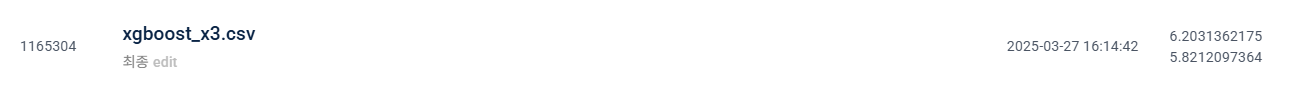

- 세 가지 회귀 모델 모두 train3 (송하인_카테고리별_변수 / 정규화데이터 / 이상치 삭제)에서 가장 성능이 좋음
- xgboost의 성능이 가장 좋음